In [134]:
%cd ../src
%load_ext autoreload
%autoreload 2

/home/ubuntu/SPVD_Lightning/src
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
from models.ddpm_unet_cattn import SPVUnet
import torch
import lightning as L
from models.g_spvd import GSPVD

In [136]:
from torch.utils.data import DataLoader
from dataloaders.shapenet.shapenet_loader import ShapeNet

path = "../data/ShapeNet"
categories = ['car']
test_dataset = ShapeNet(path, "test", 2048, categories, load_renders=True, total=100)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4)

Loading (test) renders for car (02958343):   0%|          | 0/704 [00:00<?, ?it/s]

In [137]:
from utils.hyperparams import load_hyperparams

hparams_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/hparams.yaml'

hparams = load_hyperparams(hparams_path)

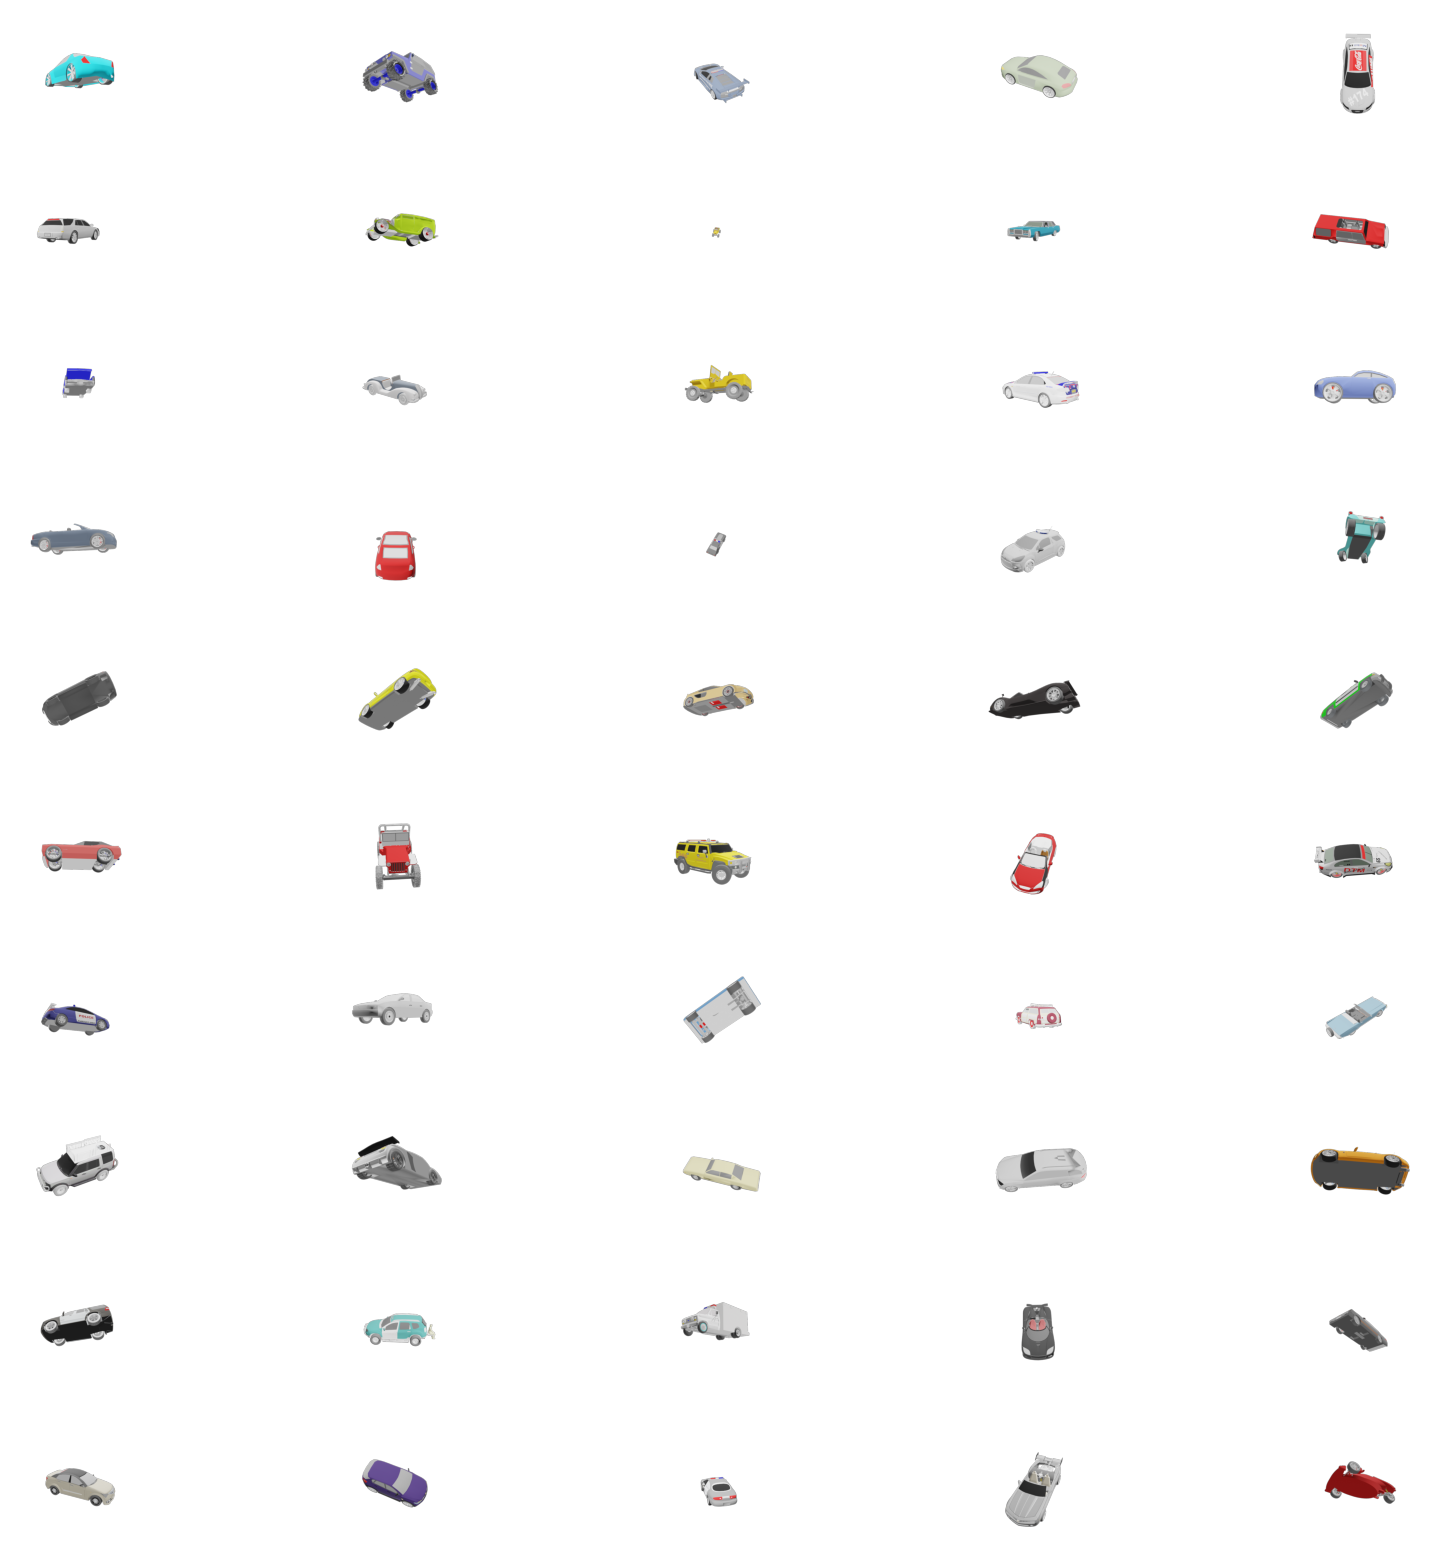

In [138]:
from PIL import Image
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 5, figsize=(20, 20))

offset = 0
for i in range(50):
    r = test_dataset[i + offset]
    img = Image.open("../data/ShapeNet/renders/" + r['filename'] + f"/00{r['selected-view']}.png")
    
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].axis('off')
plt.show()

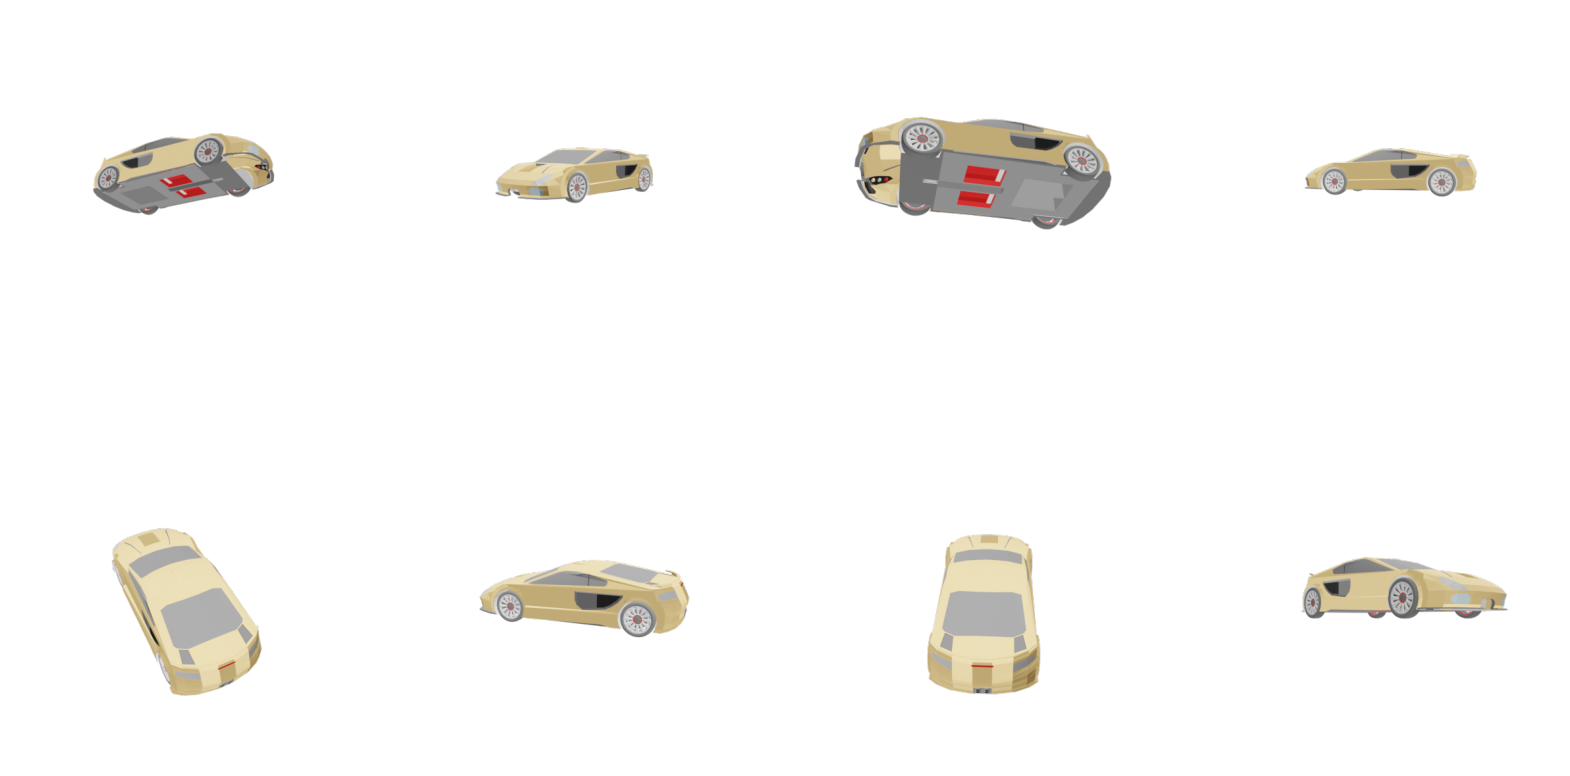

In [139]:
from PIL import Image
import matplotlib.pyplot as plt

target = 22
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i in range(8):
    r = test_dataset[target, i]
    img = Image.open("../data/ShapeNet/renders/" + r['filename'] + f"/00{r['selected-view']}.png")
    
    ax[i // 4, i % 4].imshow(img)
    ax[i // 4, i % 4].axis('off')
plt.show()

In [151]:
cross = None
for i in [1000, 500, 250, 125, 63, 32, 16, 8]:
    sched = DDPMSparseScheduler(
        beta_min=hparams['beta_min'],
        beta_max=hparams['beta_max'],
        steps=i,
        init_steps=hparams['n_steps'],
        mode=hparams['mode'],
    )
    s = set([j.item() for j in sched.t_steps])
    if not cross:
        cross = s
    else:
        cross = cross & s
cross = sorted(cross)

print(f"cross of steps: {cross}")

cross of steps: [103, 231, 359, 487, 615, 743, 871, 999]


In [196]:
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler
from my_schedulers.ddim_scheduler import DDIMSparseScheduler

steps = 2
ddim_sched = DDIMSparseScheduler(
    beta_min=hparams['beta_min'], 
    beta_max=hparams['beta_max'], 
    steps=steps, 
    init_steps=hparams['n_steps'],
    mode=hparams['mode'],
)

In [197]:
model_args = {
    'voxel_size' : hparams['voxel_size'],
    'nfs' : hparams['nfs'], 
    'attn_chans' : hparams['attn_chans'], 
    'attn_start' : hparams['attn_start'], 
    'cross_attn_chans' : hparams['cross_attn_chans'], 
    'cross_attn_start' : hparams['cross_attn_start'], 
    'cross_attn_cond_dim' : hparams['cross_attn_cond_dim'],
}

model = SPVUnet(**model_args)
model = GSPVD(model=model)

In [198]:
from utils.helper_functions import process_ckpt

ckpt_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/new/{steps}-steps.ckpt'
ckpt = torch.load(ckpt_path, weights_only=False)
ckpt = process_ckpt(ckpt)
model.load_state_dict(ckpt)
model = model.eval().cuda()

In [199]:
selected = ((27, 6), (22, 3))
ref = torch.stack([test_dataset[i]['render-features'] for i in selected]).cuda()
pred, x0 = ddim_sched.sample(model, len(selected), 2048, 3, reference=ref, save=True)

Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

In [200]:
from utils.visualization import display_pointclouds_grid
import numpy as np

display = []

for idx, t in enumerate(ddim_sched.t_steps):
    if t.item() in cross:
        display.append(x0[idx])
        
display.append(x0[-1])
display = np.array(display)

display_notebook = display.reshape(-1, 2048, 3)

display_pointclouds_grid(display_notebook, offset=10, point_size=0.3, grid_dims=((len(cross) + 1), len(selected)))

Output()

In [201]:
from utils.helper_functions import send_to_local
print(display[:, 0].shape)
r1 = test_dataset[selected[0]]
r2 = test_dataset[selected[1]]
send_to_local(display[:, 0], r1['filename'], r1['selected-view'], f"x0/{steps}", categories[0])
send_to_local(display[:, 1], r2['filename'], r2['selected-view'], f"x0/{steps}-2", categories[0])

(3, 2048, 3)
